In [110]:
# IMPORTS AND UTILITY FUNCTIONS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from types import SimpleNamespace
from sklearn.preprocessing import MinMaxScaler
from utils import *
from IPython.display import display, Markdown, HTML 
import markdown2

pd.set_option("display.max_rows", 100)
df_demo = get_demographics_data()

print(" & ".join(df_demo['participant'].unique()))
print(f"NUM PARTICIPANT: {len(df_demo['participant'].unique())}")

#print(df_demo)

counts = pd.concat([df_demo[i].value_counts().reindex(['icuA', 'icuaA', 'icuB', 'icuaB']) for i in range(4)], axis=1)
print(markdown_table_to_latex(counts.to_markdown()))

print(counts.iloc[0] + counts.iloc[1])
print(counts.iloc[2] + counts.iloc[3])




P01 & P02 & P04 & P05 & P06 & P07 & P08 & P09 & P10 & P11 & P12 & P13 & P14 & P15 & P16 & P17 & P18 & P19 & P20 & P21 & P22 & P23 & P24 & P25
NUM PARTICIPANT: 24
\begin{tabular}{|c|c|c|c|c|}
\hline
 & 0 & 1 & 2 & 3  \\
\hline
 icuA & 8 & 1 & 8 & 6  \\
 icuaA & 6 & 8 & 2 & 9  \\
 icuB & 5 & 5 & 11 & 3  \\
 icuaB & 5 & 10 & 3 & 6  \\
\hline
\end{tabular}
0    14
1     9
2    10
3    15
dtype: int64
0    10
1    15
2    14
3     9
dtype: int64



## Distribution of performances
Plots show histogram over participants of their performance for each experiment. Red vertical line shows the mean.


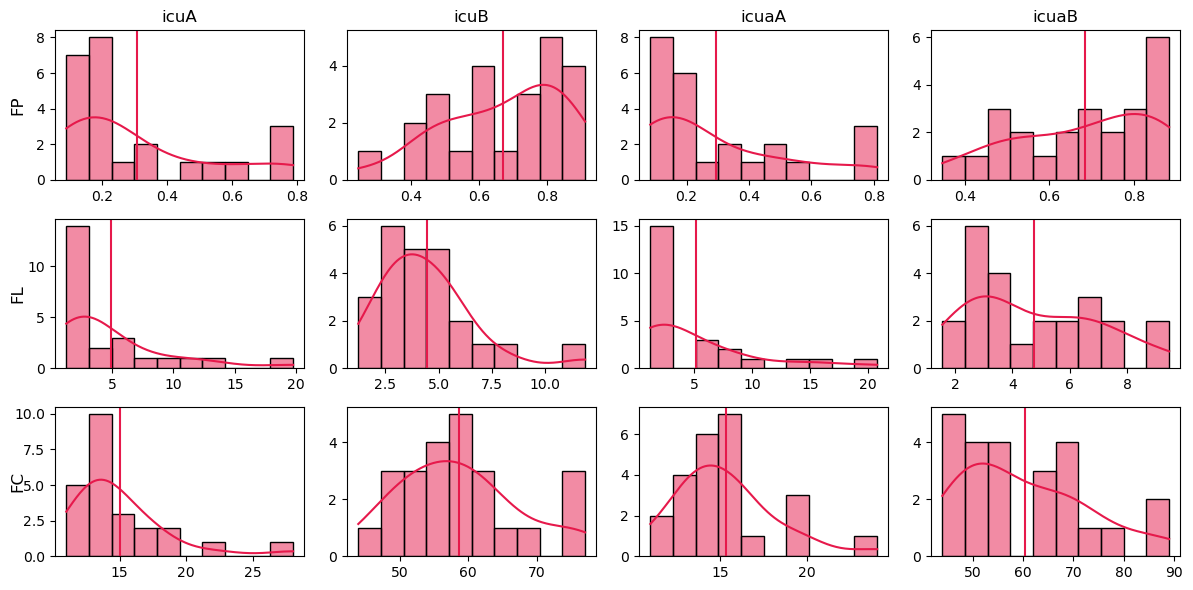

In [49]:
# VISUALISE PERFORMANCE DISTRIBUTIONS
data = load_nested_dict('data/Processed') 
df = Statistics.compute_failure_proportion_statistics()
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(12,6)) # TODO no magic, compute nrows & ncols...
fig.tight_layout()

def visualise_performance_distribution(df, axes, titles=False, label=None):
    df = df[['participant', 'experiment', 'total']]
    df = df.pivot(index='participant', columns='experiment', values='total')
    exp = df.reset_index(drop=True).select_dtypes(include="number").columns.to_list()
    ax0 = axes.ravel()[0]
    ax0.text(-0.15, 0.5, label, transform=ax0.transAxes, rotation=90, va='center', ha='center', fontsize=12)

    for c, ax in zip(exp, axes.ravel()):
        sns.histplot(df[c], ax=ax, bins=10, kde=True)
        ax.axvline(x=df[c].mean().item())
        ax.set_xlabel(None), ax.set_ylabel(None)
        if titles:
            ax.set_title(c)
            
visualise_performance_distribution(df, axes[0], titles=True, label="FP")

# NOTE: this performance is problematic, the distribution has a very long tail... some people did pretty bad! 
df = Statistics.compute_failure_length_statistics()
visualise_performance_distribution(df, axes[1], label="FL")

df = Statistics.compute_failure_count_statistics()
visualise_performance_distribution(df, axes[2], label="FC")

markdown("""
## Distribution of performances
Plots show histogram over participants of their performance for each experiment. Red vertical line shows the mean.
""")
plt.tight_layout()
plt.savefig("./results/performance-distributions.png", bbox_inches='tight')
plt.show()


#### Correlation between estimated and actual performance
 This might give some indiciation of which performance measure is a good one if we assume that the participants are reasonably good at judging their own performance.

Overall Correlation: 0.6577


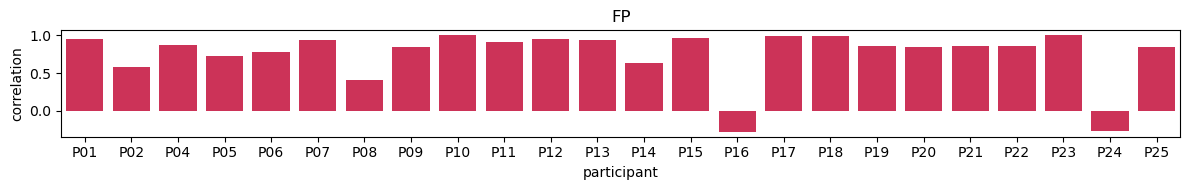

Overall Correlation: 0.1576


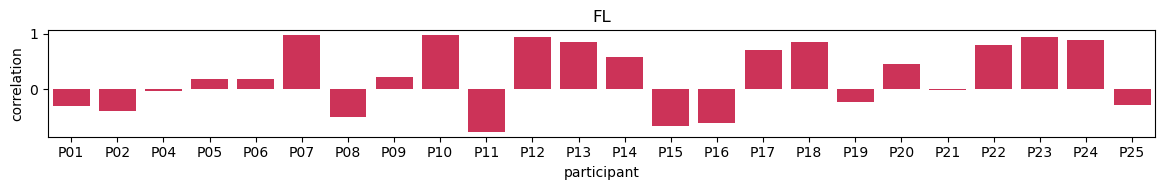

Overall Correlation: 0.7061


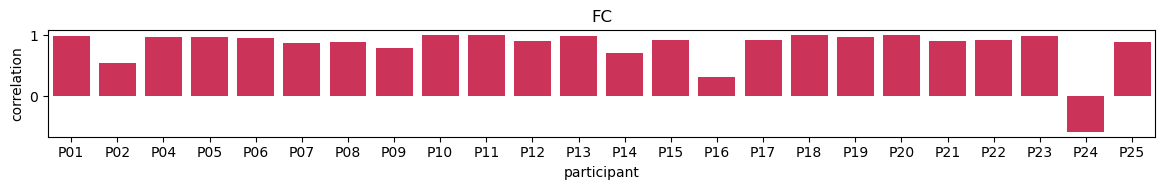

In [51]:
# visualises performance against perceived difficulty 
# Q: did the participants accurately judge difficulty? 
# A: yes, most of them except P16 and P24. Interestingly these are two of the worst performers (especially 24)

def order_score2(score):
    score = score[['participant', 'experiment', 'total']].copy()
    score['difficulty'] = score['experiment'].str[-1]
    score = score.rename(columns={'total':'score'})
    df_demo = get_demographics_data()
    df_demo = df_demo[['participant', 0, 1, 2, 3]]
    df_demo = df_demo.melt(id_vars='participant', var_name='time', value_name='experiment')
    return pd.merge(score, df_demo, on=['participant', 'experiment'])


def estimate_correlation(df_score, title):
    df_score = df_score[['participant', 'experiment', 'total']].rename(columns={'total':'score'})
    df_demo = get_demographics_data()

    df_demo = pd.concat(
    [df_demo[['participant', 0,'S0']].rename(columns={0:'experiment', 'S0':'estimate'}),
    df_demo[['participant', 1,'S1']].rename(columns={1:'experiment', 'S1':'estimate'}),
    df_demo[['participant', 2,'S2']].rename(columns={2:'experiment', 'S2':'estimate'}),
    df_demo[['participant', 3,'S3']].rename(columns={3:'experiment', 'S3':'estimate'})]).reset_index(drop=True)

    ests = ['veasy', 'easy', 'moderate', 'hard', 'vhard']
    ests = {ests[i]:i for i in range(len(ests))}
    df_demo = df_demo.replace(ests) # replace with numeric values so we can compute correlations
    df_m = pd.merge(df_score, df_demo, on=['participant', 'experiment'])
    print(f"Overall Correlation: {df_m['score'].corr(df_m['estimate']):.4f}")

    grouped_df = df_m.groupby('participant')[['score', 'estimate']].corr().reset_index()
    grouped_df = grouped_df.loc[::2][['participant', 'estimate']]
    grouped_df = grouped_df.rename(columns={'estimate':'correlation'})
    fig = plt.figure(figsize=(12,2))
    ax = sns.barplot(x='participant', y='correlation', data=grouped_df, color="#e6194B")
    #ax.set_title(f"{title} correlation of estimated and actual performance")
    ax.set_title(title)
    
    plt.tight_layout()
    plt.savefig(f"./results/{title.lower()}-estimated-actual-correlation.png", bbox_inches='tight')
    plt.show()
    
    
markdown("#### Correlation between estimated and actual performance\n This might give some indiciation of which performance measure is a good one if we assume that the participants are reasonably good at judging their own performance.")

estimate_correlation(Statistics.compute_failure_proportion_statistics(), 'FP')
estimate_correlation(Statistics.compute_failure_length_statistics(), 'FL')
estimate_correlation(Statistics.compute_failure_count_statistics(), 'FC')






## Did agents help?
 According to participants, they found it slightly more difficult with the agents assistance.

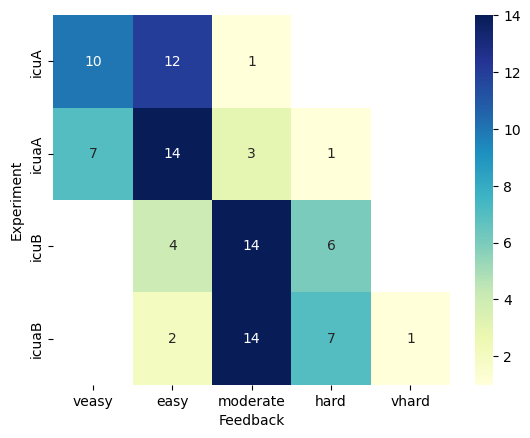

In [68]:
# Visualises actual difficulty and perceived difficulty (via feedback).
# It looks like the agents made things slightly worse here...

markdown("## Did agents help?\n According to participants, they found it slightly more difficult with the agents assistance.")
df = get_demographics_data()

counts_df = pd.DataFrame(np.concatenate([df[[i, f'S{i}']].to_numpy() for i in range(4)], axis=0))
counts_df = pd.DataFrame(counts_df.value_counts())
counts_df.columns = ['count']
counts_df = counts_df.reset_index()




# Pivot the dataframe to create a matrix-like structure
heatmap_data = counts_df.pivot(columns=1, index=0, values='count')
heatmap_data.fillna(0)
heatmap_data = heatmap_data[['veasy', 'easy', 'moderate', 'hard', 'vhard']]
heatmap_data = heatmap_data.reindex(['icuA','icuaA','icuB', 'icuaB'])
# Create the heatmap using seaborn
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu")
# Set the labels for the x-axis and y-axis
plt.xlabel('Feedback')
plt.ylabel('Experiment')
# Display the heatmap
plt.show()


In [87]:
df = get_demographics_data()

det_df = pd.DataFrame(np.concatenate([df[['participant', i, f'S{i}']].to_numpy() for i in range(4)], axis=0))
ests = ['veasy', 'easy', 'moderate', 'hard', 'vhard']
ests = {ests[i]:i for i in range(len(ests))}
det_df = det_df.replace(ests) # replace with numeric values so we can compute correlations


det_df = det_df.rename(columns={0:'participant', 1:'experiment', 2:'estimate'})
det_df['difficulty'] = det_df['experiment'].str[-1]
det_dfA = det_df[det_df['difficulty'] == "A"]
det_dfB = det_df[det_df['difficulty'] == "B"]

def det_gen(det):
    for par, group in det.groupby('participant'):
        group = group.sort_values('experiment')
        yield par, group['estimate'].iloc[1] - group['estimate'].iloc[0] # if positive then they thought it was harder with agents

det_dfA = pd.DataFrame(det_gen(det_dfA), columns=['participant', 'det'])
det_dfB = pd.DataFrame(det_gen(det_dfB), columns=['participant', 'det'])

#print(det_dfA)

print(df[df['participant'].isin(det_dfB[det_dfB['det'] > 0]['participant'])])
print(df[df['participant'].isin(det_dfA[det_dfA['det'] < 0]['participant'])])



print(f"Difficulty A: No change: {(det_dfA['det'] == 0).sum()} Harder w/a: {(det_dfA['det'] > 0).sum()} Easier w/a: {(det_dfA['det'] < 0).sum()} ")
print(f"Difficulty B: No change: {(det_dfB['det'] == 0).sum()} Harder w/a: {(det_dfB['det'] > 0).sum()} Easier w/a: {(det_dfB['det'] < 0).sum()} ")




   participant      0      1      2      3        S0        S1        S2  \
1          P02   icuA   icuB  icuaB  icuaA     veasy      easy      hard   
4          P05   icuB  icuaB   icuA  icuaA  moderate      hard      easy   
6          P07  icuaA  icuaB   icuB   icuA     veasy  moderate      easy   
8          P09  icuaA  icuaB   icuB   icuA      easy      hard  moderate   
12         P13   icuA  icuaB  icuaA   icuB      easy      hard      easy   
15         P16  icuaA   icuB  icuaB   icuA  moderate      easy  moderate   
16         P17  icuaB  icuaA   icuB   icuA      hard     veasy  moderate   
18         P19   icuB  icuaA   icuA  icuaB      hard      easy      easy   
24         P25   icuA  icuaB   icuB  icuaA     veasy      hard  moderate   

          S3  
1   moderate  
4       easy  
6      veasy  
8       easy  
12  moderate  
15     veasy  
16      easy  
18     vhard  
24      easy  
   participant      0      1     2      3        S0     S1        S2     S3
11         P1

In [ ]:
# OLD BELOW IGNORE

In [3]:
## VISUALISE PERFORMANCE AND PERCEIVED DIFFICULTY.

def get_task_counts():
    df = get_demographics_data()
    #print(len(df['participant']))
    exp = sorted(df[[0,1,2,3]].melt()['value'].unique())
    def gen():
        for column in df[[0,1,2,3]].columns:
            vcounts = df[column].value_counts().reset_index()
            vcounts.columns = ['experiment', 'count']
            #print(vcounts)
            value_counts = {k:0 for k in exp}
            value_counts.update(dict(zip(vcounts[vcounts.columns[0]], vcounts['count'])))
            yield value_counts
    return pd.DataFrame(gen())

# invert should be used to ensure that higher scores mean better performance.
def get_ordered_scores(failure_statistic, invert=False):
    data = load_nested_dict('data/Processed') 
    df_p = failure_statistic(data)
    df_p = df_p[['participant', 'experiment', 'total']]
    df_p = df_p.pivot(index='participant', columns='experiment', values='total')
    exp = df_p.reset_index(drop=True).select_dtypes(include="number").columns.to_list()
    
    # correction weights as the distribution of experiment orderings is not uniform
    weights = get_task_counts().sort_index(axis=1) # this is not needed if we correct as below.
    # weights = weights / weights.sum(axis=0)
  
    df_demo = get_demographics_data()
    df_p = df_p.reset_index()
    if invert: # invert scores so that the higher the score the better the participant did
        ncols = df_p.select_dtypes(include='number').columns
        score_max = df_p[ncols].max().max()
        df_p[ncols] = score_max - df_p[ncols]
    
    def order_scores(df_p):
        for (i, drow), (i, prow) in zip(df_demo[['participant',0,1,2,3]].iterrows(), df_p.iterrows()):
            assert drow['participant'] == prow['participant']
            drow = drow.to_list()        
            #yield [drow[0]] + [prow[i] / weights[i].iloc[j] for j,i in enumerate(drow[1:])] # create a new row ordered
            yield [drow[0]] + [prow[i] for i in drow[1:]] # reorder
        
    # just use weights of 1
    # weights1 = weights.copy()
    # weights1.loc[:,:] = 1.
    
    df_score_raw = pd.DataFrame(order_scores(df_p), columns=['participant',0,1,2,3])
    # correct for difference in difficulty. This is quite crude as the distributions are not gaussian...
    df_c = df_p.copy()
    df_c[exp] = df_c[exp] - df_c[exp].mean() 
    df_score_corrected = pd.DataFrame(order_scores(df_c), columns=['participant',0,1,2,3])
    
    ncols = df_score_raw.select_dtypes(include='number').columns
    mean_score = df_score_raw[ncols].mean().to_numpy()
    mean_score_corrected = df_score_corrected[ncols].mean().to_numpy()
    
    return SimpleNamespace(
            score=df_score_raw, 
            score_corrected=df_score_corrected,
            mean=pd.DataFrame(data={'mean score':mean_score, 'mean score corrected':mean_score_corrected}),
            weights=weights
    )
        
        
markdown("""
# Performance & Perceived Difficulty
Statistics of participant performance in time order. Higher scores mean better performance. If participants are improving with time, we should see scores going up.
""")

score_fp = get_ordered_scores(compute_failure_proportion_statistics)    # low = better
markdown("Time ordered distribution of experiments:")
markdown(score_fp.weights.to_markdown()) 


print(markdown_table_to_latex(score_fp.weights.to_markdown()))

tables, headers = [], []
headers.append("Failure proportion")
tables.append(score_fp.mean.to_markdown())

score_il = get_ordered_scores(compute_failure_length_statistics) # low = better
headers.append("Failure interval length")
tables.append(score_il.mean.to_markdown())

score_fc = get_ordered_scores(compute_failure_count_statistics) # low = better
headers.append("Failure count")
tables.append(score_fc.mean.to_markdown())

markdown("Scores are corrected for difficulty by subtracting the mean (over participants) of each task from corresponding individual scores.")
embed_markdown_tables(tables, ncols=len(headers), headers=headers)
# NOTE: 4 trials per participant is not really enough to measure a trend.

for table in tables:
    print(markdown_table_to_latex(table))





# Performance & Perceived Difficulty
Statistics of participant performance in time order. Higher scores mean better performance. If participants are improving with time, we should see scores going up.


NameError: name 'compute_failure_proportion_statistics' is not defined

In [4]:

# LINEAR REGRESSION OF CORRECTED SCORES

markdown("""## Regressing Corrected Scores:\n Depending on the performance measure we either see a slight improvement or we don't. 
         I think it is safe to say that the participants didn't improve with time.""")

def plot_regression(score, title=None):
    fig = plt.figure(figsize=(8,3))
    from sklearn.linear_model import LinearRegression
    ncols = score.score_corrected.select_dtypes(include='number').columns
    df = score.score_corrected[ncols].melt(var_name='X', value_name='Y')
    # Create an instance of the LinearRegression model
    x, y = df['X'].to_numpy(), df['Y'].to_numpy()
    model = LinearRegression()
    model.fit(x[:,np.newaxis], y)
    slope = model.coef_
    intercept = model.intercept_
    print(f"{title}: slope: {slope} intercept: {intercept}")
    plt.gca().scatter(x,y, color="#e6194B")
    x_line = np.linspace(np.min(x), np.max(x), 100)
    plt.gca().plot(x_line, slope * x_line + intercept, color="#e6194B")
    plt.show()
    
plot_regression(score_fp, title="failure proportion (FP)")
plot_regression(score_il, title="failure interval length (FL)")
plot_regression(score_fc, title="failure count (FC)")

markdown("Note that the outliers can drastially change the trend here... see especially plot 2 (FL).")

markdown("### Tentative conclusion:\n It seems that there is a little improvement over time for FP and FL, but that there is a decrease in FC. Essentially, people went into failure more but they stayed in failure for less total time.")

markdown("__NEXT STEPS?__ remove outliers and see if the trends still hold?")

## Regressing Corrected Scores:
 Depending on the performance measure we either see a slight improvement or we don't. 
         I think it is safe to say that the participants didn't improve with time.

NameError: name 'score_fp' is not defined